In [192]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt2
import random

In [193]:
window = 4
# shape[#number of feature, the window size, the output size]
shape = [2, window, 1]
# the number of neurons in each layer
neurons = [128,128,32,1]
# dropout rate
d=0.2

In [197]:
# normalize input data
def standard_scaler(stock_name, normalize=True):
#     df = pd.read_excel('/Users/mrdoggie/Desktop/stock_price.xlsx', sheetname=stock_name) # use this if sentiment info exists
    df = pd.read_excel('/Users/mrdoggie/Desktop/stock_with_sentiment.xlsx', sheetname=stock_name) # use this if sentiment info exists
#     df = pd.read_excel('stock_price.xlsx', sheetname=stock_name) # use this if only stock info
    # if only stock info exists, normalize the stock info use min-max 
    if shape[0]==1 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
    # if price and stock info exists
    if shape[0]==2 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
        # first z-score normalization, then min-max normalization
        scaler = StandardScaler()
        scaler.fit(df['opinion'].values.reshape(-1,1))
        df['opinion'] = scaler.transform(df['opinion'].values.reshape(-1,1))
        df['opinion'] = min_max_scaler.fit_transform(df['opinion'].values.reshape(-1,1))
    return df

# reformat the input according to the window size
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    plt2.plot(data.T[-1], color='red', label='price')
#     plt2.plot(data.T[0][0:30], color='blue', label='opinion')
    plt2.legend(loc='upper left')
    plt2.show()
    
    sequence_length = seq_len + 1
    result = []
    # group according to the window size
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    # 10% as hold-out data
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    # generate train and test data
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [198]:
def build_model(layers, neurons, d):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        neurons[0],
        input_shape =(layers[1],layers[0]),
        return_sequences=True))
    model.add(Dropout(d))
    
    model.add(LSTM(
        neurons[1],
        input_shape=(layers[1],layers[0]),
        return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(neurons[2], activation='relu', kernel_initializer='uniform'))
    model.add(Dense(neurons[3], activation='linear', kernel_initializer='uniform'))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    model.summary()
    return model


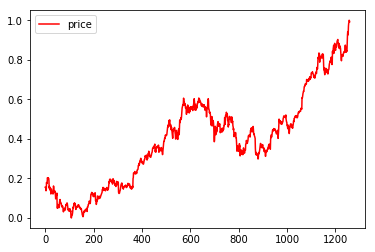

('X_train', (1130, 4, 2))
('y_train', (1130,))
('X_test', (125, 4, 2))
('y_test', (125,))


In [199]:
df = standard_scaler('AAPL', normalize=True)

X_train, y_train, X_test, y_test = preprocess_data(df, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

In [200]:
model = build_model(shape, neurons, d)

('Compilation Time : ', 0.04635000228881836)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_185 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_186 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_186 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

In [201]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=200,
    validation_split=0,
    verbose=0)

In [202]:
pred = model.predict(X_test)
print pred

[[ 0.78477669]
 [ 0.79164612]
 [ 0.79125309]
 [ 0.78499418]
 [ 0.77701312]
 [ 0.77070743]
 [ 0.77775311]
 [ 0.7796793 ]
 [ 0.78235334]
 [ 0.78302598]
 [ 0.78329045]
 [ 0.78392971]
 [ 0.7834481 ]
 [ 0.78487271]
 [ 0.78422487]
 [ 0.78491163]
 [ 0.78544676]
 [ 0.78386199]
 [ 0.78136128]
 [ 0.77213109]
 [ 0.75454861]
 [ 0.73596144]
 [ 0.72430563]
 [ 0.71955705]
 [ 0.71576965]
 [ 0.71129167]
 [ 0.71614778]
 [ 0.72685397]
 [ 0.72759426]
 [ 0.73269147]
 [ 0.7286551 ]
 [ 0.7256285 ]
 [ 0.72425425]
 [ 0.71930188]
 [ 0.71774292]
 [ 0.71082336]
 [ 0.70713401]
 [ 0.70937967]
 [ 0.71174693]
 [ 0.71461391]
 [ 0.72249484]
 [ 0.7214576 ]
 [ 0.72949219]
 [ 0.73730731]
 [ 0.74493062]
 [ 0.7508359 ]
 [ 0.7552042 ]
 [ 0.76011664]
 [ 0.76415044]
 [ 0.7677722 ]
 [ 0.76993024]
 [ 0.76715571]
 [ 0.76341158]
 [ 0.7570073 ]
 [ 0.75318217]
 [ 0.76051819]
 [ 0.77315331]
 [ 0.78729874]
 [ 0.80480766]
 [ 0.80386996]
 [ 0.81493068]
 [ 0.81877929]
 [ 0.81898826]
 [ 0.82256365]
 [ 0.81942999]
 [ 0.83200246]
 [ 0.83669

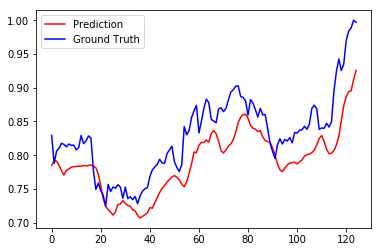

0.604838709677


In [203]:
plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

f_star=[]
f = []
v_star=[]
v=[]
# # calculate the volatility and check whether the price is growing or decreasing
for i in range(pred.size-1):
    f_star.append((pred[i+1]-pred[i]>0))
    f.append((y_test[i+1]-y_test[i])>0)
counter = 0
# count the number of correct prediction
for i in range(len(f)):
    if f_star[i][0] == f[i]:
        counter += 1
acc = counter * 1.0 / (len(f))
print acc

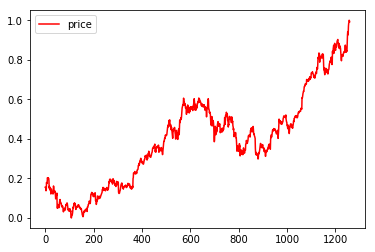

('Compilation Time : ', 0.04860496520996094)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_143 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_144 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_144 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

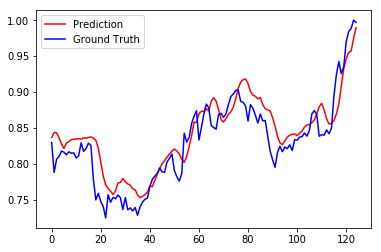

window: 4 accuracy: 0.596774193548


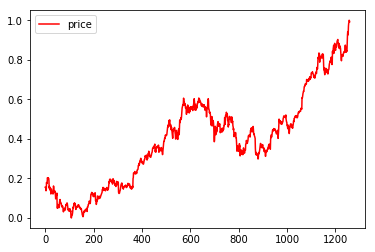

('Compilation Time : ', 0.03770899772644043)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_145 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_145 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_146 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_146 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

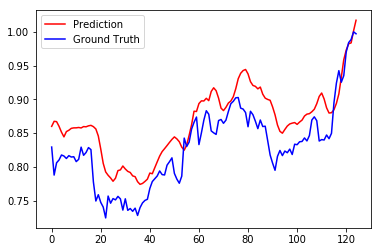

window: 4 accuracy: 0.596774193548


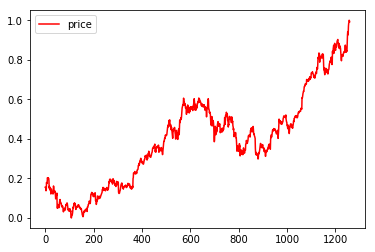

('Compilation Time : ', 0.03979897499084473)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_147 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_148 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_148 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

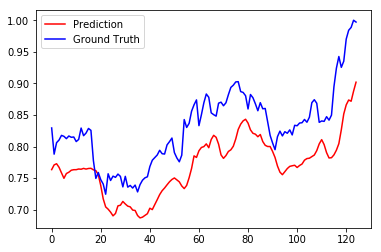

window: 4 accuracy: 0.596774193548


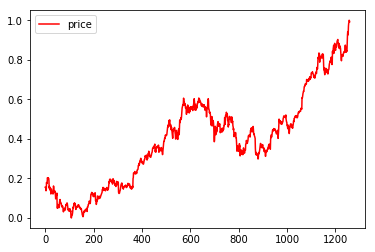

('Compilation Time : ', 0.036804914474487305)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_149 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_149 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_150 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_150 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
________________________

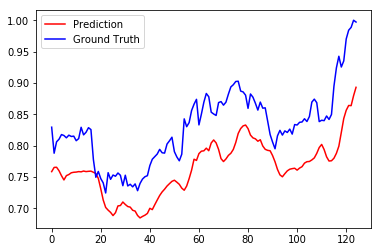

window: 4 accuracy: 0.604838709677


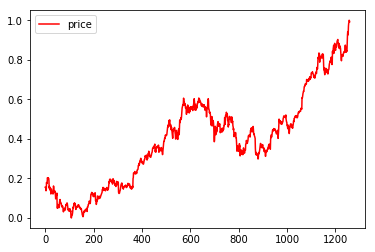

('Compilation Time : ', 0.03860807418823242)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_151 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_151 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_152 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_152 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

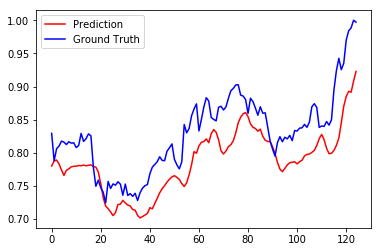

window: 4 accuracy: 0.604838709677


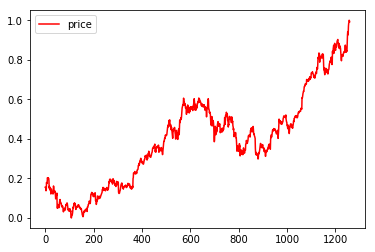

('Compilation Time : ', 0.03855109214782715)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_153 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_153 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_154 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_154 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

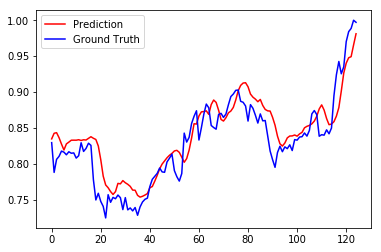

window: 4 accuracy: 0.629032258065


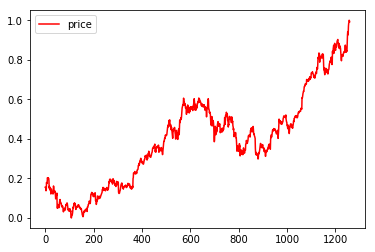

('Compilation Time : ', 0.038401126861572266)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_155 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_156 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
________________________

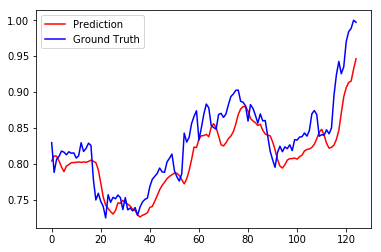

window: 4 accuracy: 0.629032258065


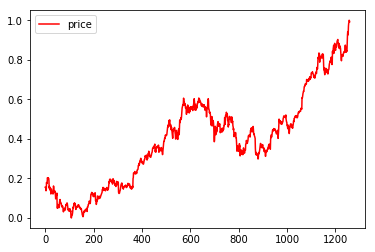

('Compilation Time : ', 0.03691411018371582)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_157 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_157 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_158 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_158 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

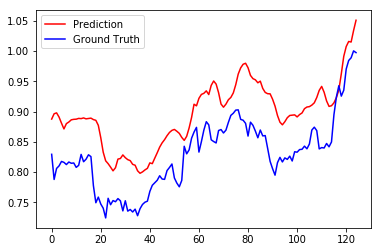

window: 4 accuracy: 0.604838709677


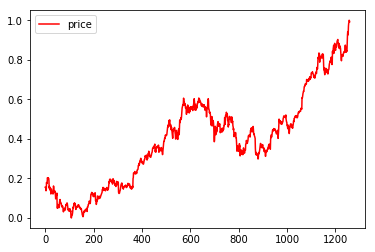

('Compilation Time : ', 0.04200410842895508)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_159 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_159 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_160 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_160 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

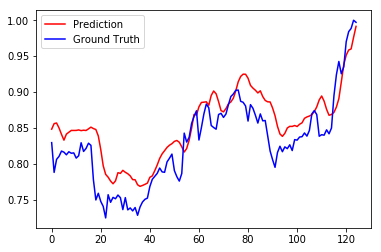

window: 4 accuracy: 0.629032258065


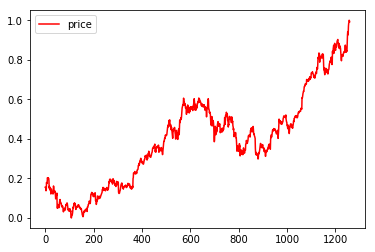

('Compilation Time : ', 0.04734396934509277)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_161 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_162 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

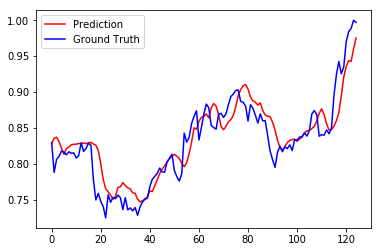

window: 4 accuracy: 0.604838709677


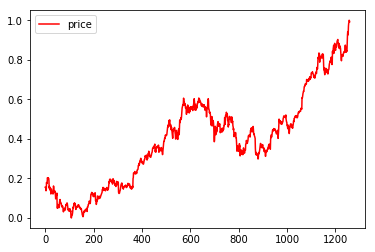

('Compilation Time : ', 0.05026984214782715)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_163 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_163 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_164 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_164 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

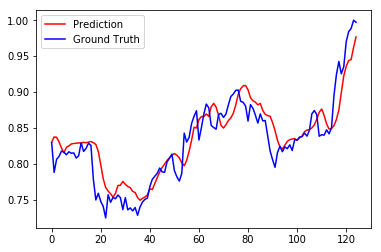

window: 4 accuracy: 0.604838709677


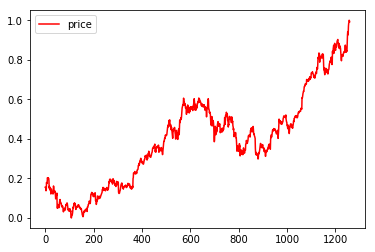

('Compilation Time : ', 0.046878814697265625)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_165 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_165 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_166 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_166 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
________________________

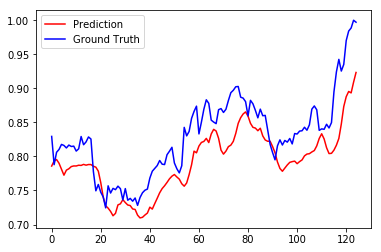

window: 4 accuracy: 0.612903225806


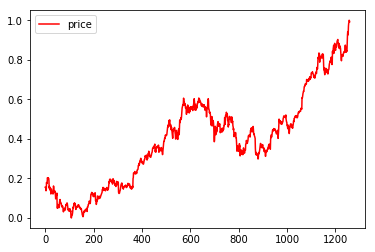

('Compilation Time : ', 0.04656410217285156)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_167 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_167 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_168 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_168 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

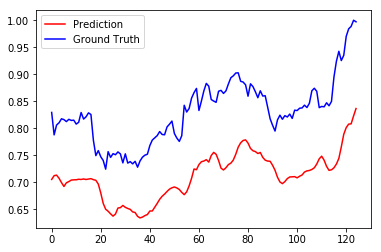

window: 4 accuracy: 0.620967741935


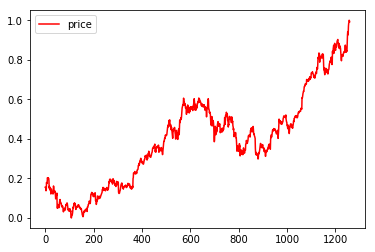

('Compilation Time : ', 0.03686690330505371)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_169 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_169 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_170 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_170 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

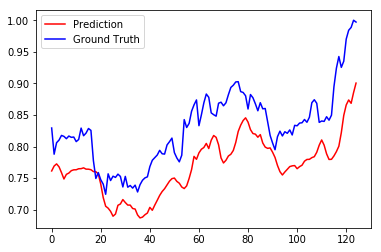

window: 4 accuracy: 0.604838709677


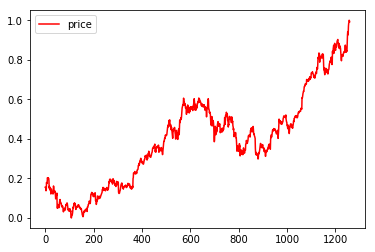

('Compilation Time : ', 0.03878617286682129)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_171 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_171 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_172 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_172 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

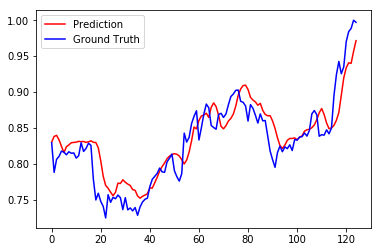

window: 4 accuracy: 0.604838709677


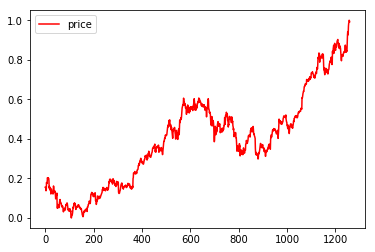

('Compilation Time : ', 0.037489891052246094)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_173 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_173 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_174 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_174 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
________________________

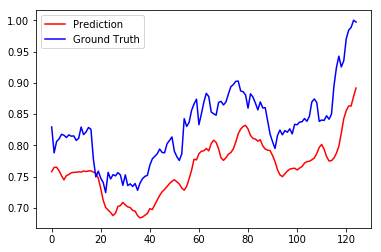

window: 4 accuracy: 0.612903225806


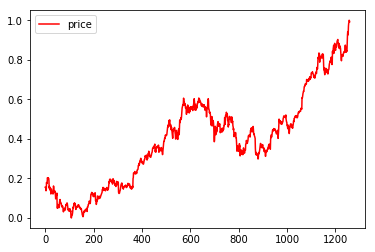

('Compilation Time : ', 0.03714609146118164)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_175 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_175 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_176 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_176 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

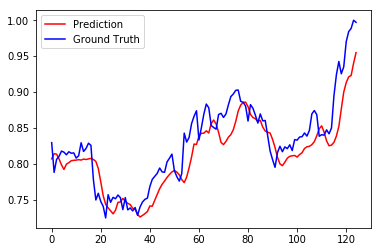

window: 4 accuracy: 0.604838709677


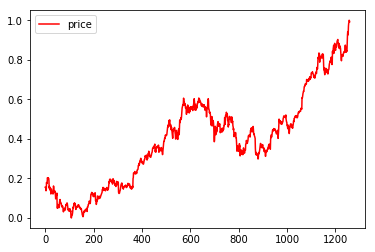

('Compilation Time : ', 0.04053807258605957)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_177 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_177 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_178 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_178 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

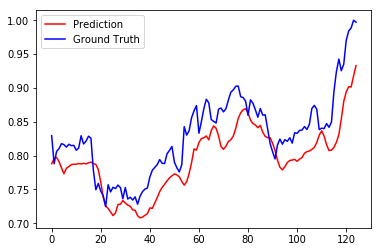

window: 4 accuracy: 0.604838709677


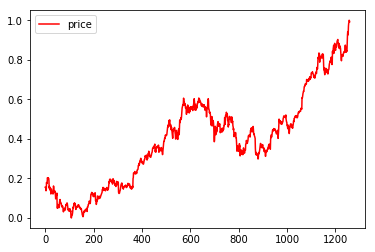

('Compilation Time : ', 0.03706812858581543)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_179 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_180 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_180 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

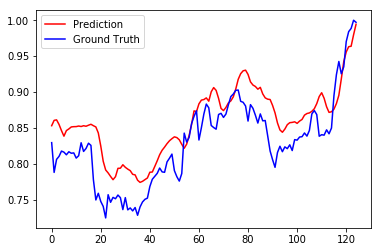

window: 4 accuracy: 0.620967741935


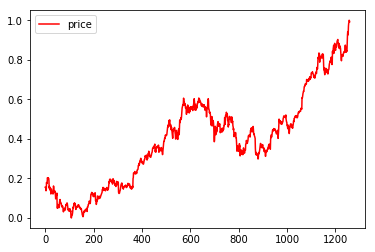

('Compilation Time : ', 0.04947495460510254)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_181 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_181 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_182 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_182 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

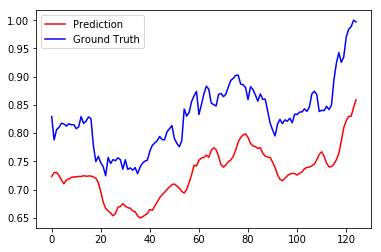

window: 4 accuracy: 0.612903225806


In [182]:
# same code as above, iterate through different window size
for i in range(0,20):
    for window in range(4,5):
        # window = 4
        shape = [2, window, 1]
        neurons = [128,128,32,1]
        d=0.2
        df = standard_scaler('AAPL', normalize=True)

        # X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
        X_train, y_train, X_test, y_test = preprocess_data(df, window)

        model = build_model(shape, neurons, d)

        model.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=200,
            validation_split=0,
            verbose=0)

        pred = model.predict(X_test)

        plt2.plot(pred, color='red', label='Prediction')
        plt2.plot(y_test, color='blue', label='Ground Truth')
        plt2.legend(loc='upper left')
        plt2.show()

        f_star=[]
        f = []
        v_star=[]
        v=[]
        for i in range(pred.size-1):
            f_star.append((pred[i+1]-pred[i]>0))
            f.append((y_test[i+1]-y_test[i])>0)
        counter = 0
        for i in range(len(f)):
            if f_star[i][0] == f[i]:
                counter += 1
        acc = counter * 1.0 / (len(f))
        print "window: "+str(window)+" accuracy: " + str(acc)
